# Group atlas Training Example
This jupyter notebook is to demonstrate a minimal example for generating group cerebellar parcellations using the Hierarchical Baysian Parcellation framework. Traditionally, the previous studies usually use single dataset to generate group-level parcellation, limiting the parcellation to identify comprehensive functional boundaries. To address this, our ``HierarchBayesParcel`` framework is designed to learn parcellation from multiple datasets fusion, resulting the resultant group (and individual) map has the combined strength.

The pipeline has two main steps: 
* Preparing training data and their condition and partition vectors.
* Building the full model from training, then get the resultant group atlas.

For data import and export we are using the [Functional_Fusion](https://github.com/DiedrichsenLab/Functional_Fusion) Framework, which needs to be installed in addition to the `HierarchBayesParcel` package.

In [1]:
import numpy as np
import torch as pt
import nibabel as nb
import nitools as nt
import pandas as pd
import matplotlib.pyplot as plt
import Functional_Fusion.atlas_map as am
import Functional_Fusion.dataset as ds
import HierarchBayesParcel.arrangements as ar
import HierarchBayesParcel.emissions as em
import HierarchBayesParcel.full_model as fm
import HierarchBayesParcel.util as ut
import SUITPy as suit

## Step 1: Define the the space in which to generate the group parcellations

This step defines the atlas space (e.g. fs32k, SUIT, MNISymC3, etc) - an atlas in Functional_Fusion defines a specific set of brainlocations (grayordinates) that are being sampled. Both the probabilistic atlas and the data need to be read into this space.

In [2]:
atlas, _ = am.get_atlas('MNISymC3')

## Step 2: Load atlas training data

For model training, the data of all subjects needs to be arranged into a `num_subj` x `N` x `P` tensor, where N is the number of observations, and P is the number of brain locations (voxels). If the group atlas is desired to be trained from datasets fusion, the training data is a list of `num_subj` x `N` x `P` tensors with each one corresponding to one datasets.

In this example, we will showcase how to train a group atlas from two datasets fusion, a task-based dataset `MDTB` and a resting-state dataset `HCP`. For MDTB dataset, we will use the task set A of all 24 subjects data with two repetitions. For HCP data, we use the first two resting-state imaging runs of the first 10 subjects of the *Unrelated 100 dataset*.

To estimate the concentration parameter $\kappa$ efficiently, it is useful to have multiple measures of the same conditions. THe `HierarchBayesParcel` framework provides multiple choices when estimating $\kappa$, hence, efficiently capturing the measurement noise across sessions or functional regions (see the paper for more details). 

Depending on the goal in mind, user can applied different types of training model, then the preparation of data can be different. In this example, the type 2 fusion model will be used, which means there is an common $\kappa$ to quantify the overall measurement noise of the dataset.

### 2.1: Assemble the MDTB data

The MDTB task set A has 29 unique conditions, and there are two repetitions per condition.

In [3]:
data_dir = 'data_mdtb'
# Read the participant tsv file to get the name of the available subjects
subj_info = pd.read_csv(f'{data_dir}/participants.tsv',sep='\t')
data = []
# Read the data for each subject
for i, s in enumerate(subj_info['participant_id']):
        file_name = f'{data_dir}/{s}_space-{atlas.name}_ses-s1_CondHalf.dscalar.nii'
        datafile = nb.load(file_name)
        data.append(datafile.get_fdata())
# make the numsubj x numcond x numvoxel tensor
data_mdtb = np.stack(data)
print(data_mdtb.shape)

(24, 58, 5446)


Then, we make the condition and partition vectors for the data, where 1d vector `cond_v_mdtb` indicates the number of the condition and the 1d vector `part_v_mdtb` indicates the number of independent data partition (e.g. runs). **Note that the length of condition and partition vector should exactly match the second dimension of the data tensor**.

In [4]:
info = pd.read_csv(f'{data_dir}/info-CondHalf.tsv',sep='\t')
cond_v_mdtb = info['cond_num_uni'].values
part_v_mdtb = info['half'].values
print('condition vector: ', cond_v_mdtb)
print('partition vector: ', part_v_mdtb)

condition vector:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19
 20 21 22 23 24 25 26 27 28 29]
partition vector:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


### 2.2: Assemble the HCP data

The HCP example data is the resting-state functional connectivity profile from the first two runs (~15 min each). The connectivity profile at each cerebellar voxel was calculated as the correlation to the 69 spatial ICA network per each run.

In [5]:
data_dir = 'data_hcp'
# Read the participant tsv file to get the name of the available subjects
subj_info = pd.read_csv(f'{data_dir}/participants.tsv',sep='\t')
data = []
# Read the data for each subject
for i, s in enumerate(subj_info['participant_id']):
        file_name = f'{data_dir}/{s}_space-{atlas.name}_ses-rest1_Net69Run.dscalar.nii'
        datafile = nb.load(file_name)
        data.append(datafile.get_fdata())
# make the numsubj x numcond x numvoxel tensor
data_hcp = np.stack(data)
print(data_hcp.shape)

(10, 138, 5446)


Similarly, we maek the condition and partiton vector for the HCP data, where we treat each run as an independent repetition.

In [6]:
info = pd.read_csv(f'{data_dir}/info-Net69Run.tsv',sep='\t')
cond_v_hcp = info['net_id'].values
part_v_hcp = info['half'].values
print('condition vector: ', cond_v_hcp)
print('partition vector: ', part_v_hcp)

condition vector:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69  1  2  3
  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51
 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69]
partition vector:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


## Step 3: Build training model

First, the probabilistic atlas is encoded in the `arrangement model`. Depending on whether you want an symmetric or asymmetric individual parcellations, you can choose a `ArrangeIndependent` or `ArrangeIndependentSymmetric` model.

Second, we need to build the emission model to the data. In this example, we use type 2 fusion model, which estimates the average functional profiles for each region ($V$) and the concentration parameter ($\kappa$) for the von Mises-Fisher distribution.

Lastly, we assemble the arrangement and emission models as a full learning model.

In [7]:
# Determine the resolution of the atlas
K=10
# Build spatial arrangement model
ar_model = ar.ArrangeIndependent(K, atlas.P, spatial_specific=True, 
                                 remove_redundancy=False)
# Build emission models for each dataset
em_model_mdtb = em.MixVMF(K=K, P=atlas.P, X=ut.indicator(cond_v_mdtb),
                          part_vec=part_v_mdtb, uniform_kappa=True)
em_model_hcp = em.MixVMF(K=K, P=atlas.P, X=ut.indicator(cond_v_hcp),
                         part_vec=part_v_hcp, uniform_kappa=True)

M = fm.FullMultiModel(ar_model, [em_model_mdtb, em_model_hcp])

## Step 4: Fit the full training model

Now, we initilize the full model by passing the data. Note, `subj_ind='separate'` indicates the two datasets are from different set of participants. If the two datasets, for example, are the two sessions from the same subjects, then we can pass a list of identical subject index to tell the full model they are the same subjects.

**Note, care needs to be taken when selecting the fusion model to get the best parcellation.** This example is only for a practical viewpoint of the framework, which doesn't guarantee to get the best fusion group map using the two datasets.

In [8]:
M.initialize([data_mdtb, data_hcp], subj_ind='separate')
# Since we use spatial independent model, here we will use EM training
M_fused, ll, _, U_indiv_fuse, _ = M.fit_em_ninits(iter=200, tol=0.01, fit_arrangement=True,
                                                  fit_emission=True, init_arrangement=True,
                                                  init_emission=True, n_inits=50, first_iter=30, 
                                                  verbose=False)

## Step 5: Visualize the group parcellations

Lastly, we can visually inspect the resulting parcellation by using the SUITPy toolbox to visualize these on the surface.

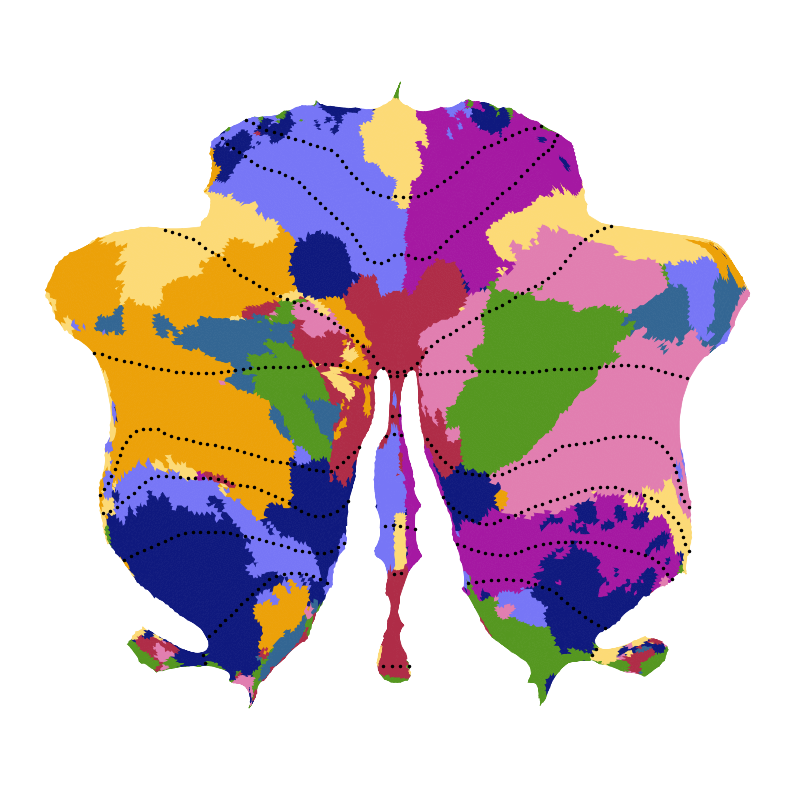

In [9]:
def plot_probseg(nifti,cmap):
    # Project the nifti image to the surface over the MNISymC space
    surf_data = suit.flatmap.vol_to_surf(nifti, stats='nanmean',space='MNISymC')
    label = np.argmax(surf_data, axis=1)+1

    suit.flatmap.plot(label,
        render='matplotlib',
        cmap=cmap,
        cscale=[0,31],
        label_names = names,
        new_figure=False,
        overlay_type='label',
        bordersize=3,
    )

# Load colormap and labels
lid,cmap,names = nt.read_lut('atl-MDTB10.lut')
# Make a nifti image of the first subject
nifti = atlas.data_to_nifti(pt.softmax(M_fused.arrange.logpi, dim=0).cpu().numpy())
# Make a figure
plt.figure(figsize=(10,10))
# plot the group probabilistic atlas
plot_probseg(nifti,cmap)

<hr>

Up to here, the above example is enough to implement the framework to train a group atlas. The belows are some useful practical guidance when user wants to learn more of our framework.

## Comparison of fusion atlas vs. single-dataset atlas

Lastly, we can visually inspect the resulting parcellation by using the SUITPy toolbox to visualize these on the surface.

In [10]:
# Train MDTB parcellation only
M1 = fm.FullMultiModel(ar_model, [em_model_mdtb])
M1.initialize([data_mdtb])
M1, ll, theta, U_hat, _ = M1.fit_em_ninits(iter=200, tol=0.01, fit_arrangement=True,
                                           fit_emission=True, init_arrangement=True,
                                           init_emission=True, n_inits=50, first_iter=30, 
                                           verbose=False)

# Train HCP parcellation only
M2 = fm.FullMultiModel(ar_model, [em_model_hcp])
M2.initialize([data_hcp])
M2, ll, theta, U_hat, _ = M2.fit_em_ninits(iter=200, tol=0.01, fit_arrangement=True,
                                           fit_emission=True, init_arrangement=True,
                                           init_emission=True, n_inits=50, first_iter=30, 
                                           verbose=False)


/home/ROBARTS/dzhi/WorkSpace/HierarchBayesParcel/HierarchBayesParcel/full_model.py:305: UserWarning: Likelihood decreased - terminating on iteration 53
  warnings.warn(f'Likelihood decreased - terminating on iteration {i}')
/home/ROBARTS/dzhi/WorkSpace/HierarchBayesParcel/HierarchBayesParcel/full_model.py:305: UserWarning: Likelihood decreased - terminating on iteration 37
  warnings.warn(f'Likelihood decreased - terminating on iteration {i}')


Different datasets highlight different functional region. However, the fused map shows the combined strength. For example, in this case, the group map trained by resting-state alone cannot predict left- and right hand motor areas. But these motor regions are visible now in the fusion map.

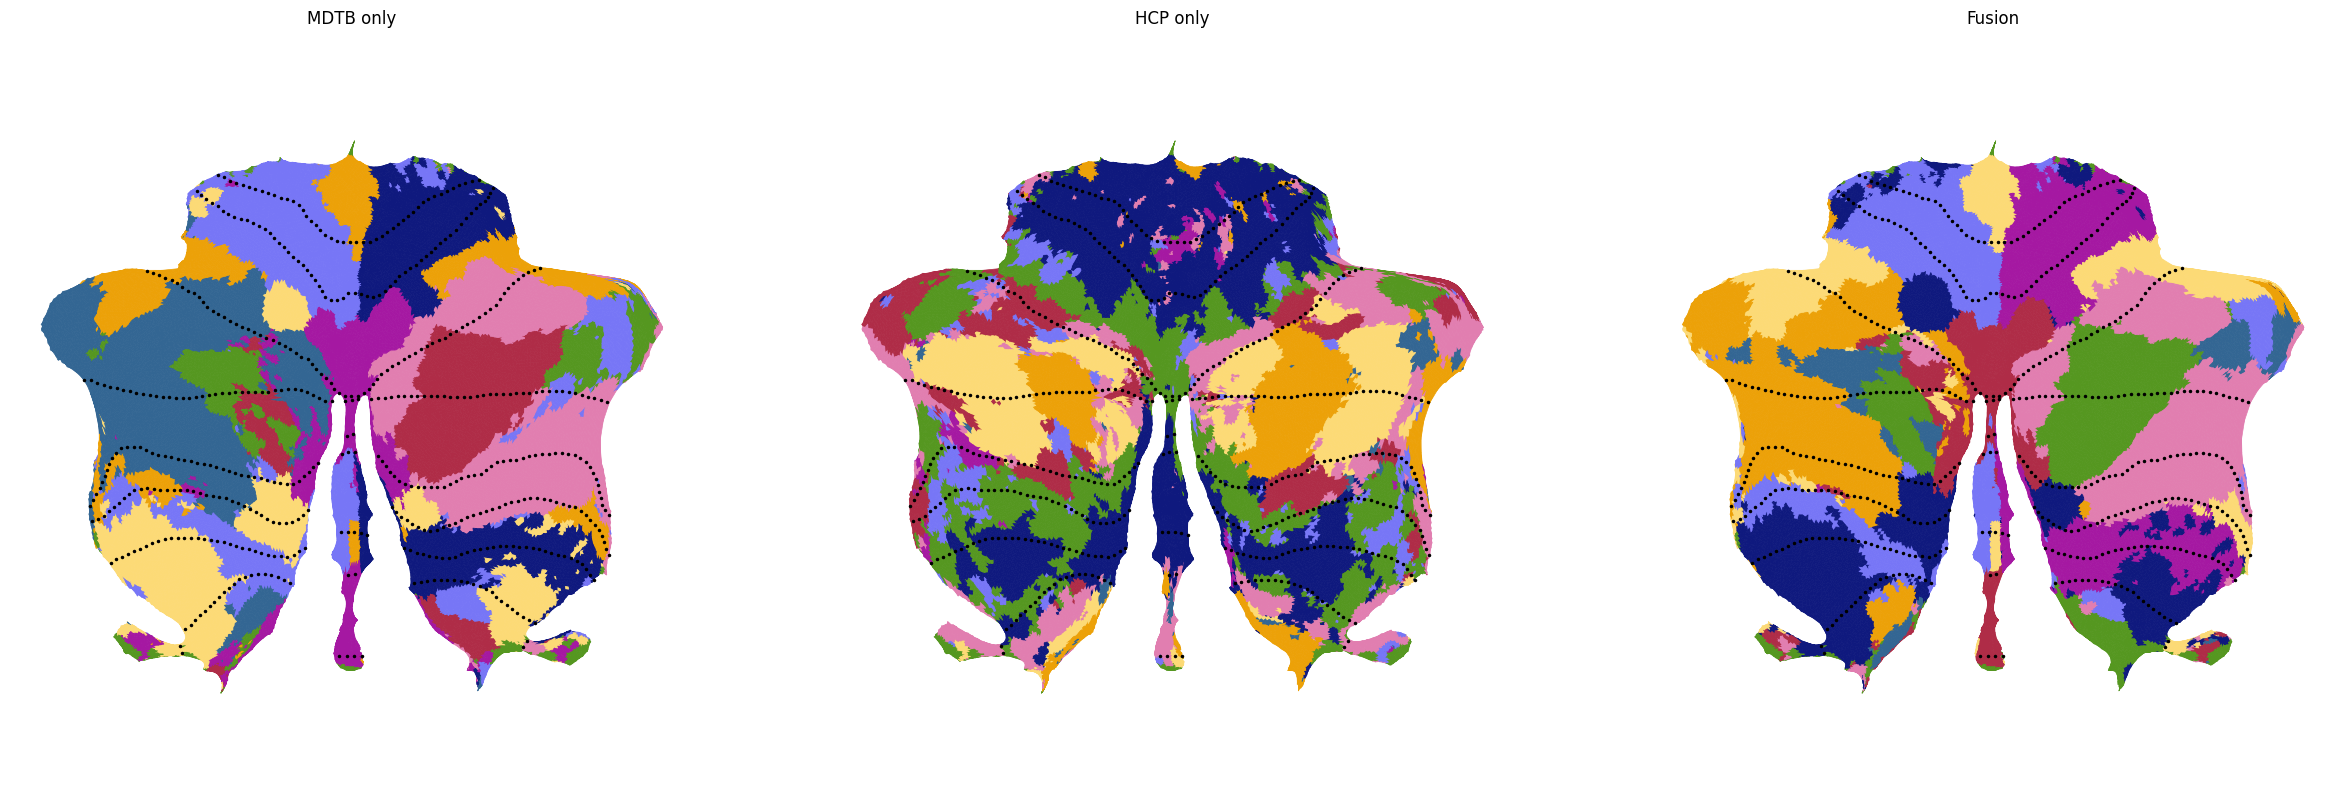

In [11]:
# plot comparison
plt.figure(figsize=(30,10))
plt.subplot(1,3,1, title='MDTB only')
nifti = atlas.data_to_nifti(pt.softmax(M1.arrange.logpi, dim=0).numpy())
plot_probseg(nifti,cmap)

plt.subplot(1,3,2, title='HCP only')
nifti = atlas.data_to_nifti(pt.softmax(M2.arrange.logpi, dim=0).numpy())
plot_probseg(nifti,cmap)

plt.subplot(1,3,3, title='Fusion')
nifti = atlas.data_to_nifti(pt.softmax(M_fused.arrange.logpi, dim=0).numpy())
plot_probseg(nifti,cmap)

## Monitoring the model training

When using a spatial independent arrangement model (including symmetric or asymmetric version), the `HierarchBayesParcel` framework uses a EM-like algorithm to maximize the objective function. In the full model fit function `fit_em_ninits()`, we also output the expected completed likelihood `ll` for each learning iteration. A visualization of the curve can help to monitor the model training if it is stucked at the local maxima. By observing the learning curve, it also gives user good intuition to fine-tuning their learning process, such as the maximum EM iteration, stopping criteria, and other hyper-parameters.

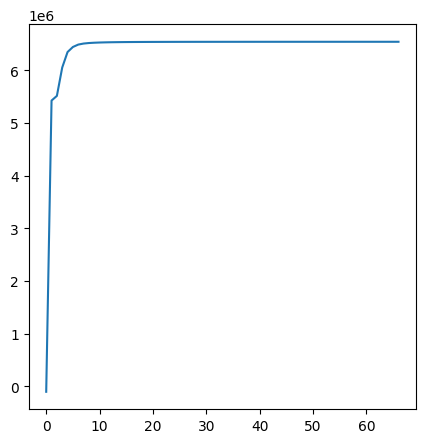

In [12]:
plt.figure(figsize=(5,5))
plt.plot(ll)

## Concentration parameter $\kappa$

Another useful tool to find whether the learning precedes correctly is to check the estimated concentration parameter $\kappa$. In this case, the type 2 model estimates a common $\kappa$ across all functional regions, while there are region-specific $\kappa$ will be learned in the type 3 model. The concentration parameter $\kappa$ is a positive scale to indicate how spread the data points are around the mean direction in high dimensional space, a higher value means the data points are more concentrated around the mean. If one or more values are observed to be abnormally low or high, it is a signal something happened in the learning.

In [13]:
print(M_fused.emissions[0].kappa, M_fused.emissions[1].kappa)

tensor(16.5644) tensor(54.8128)


## Individual parcellations directly estimated from the group training

The `HierarchBayesParcel` framework is able to output both group and the individual parcellation at the same time. The indiviual parcellations are from the same subjects in the training data, which is equivalent by running one time E-step of the full model if the data is exactly the one used for group training.

In [14]:
print(U_indiv_fuse.shape, M_fused.Estep()[0].shape)

torch.Size([34, 10, 5446]) torch.Size([34, 10, 5446])


## Avoid local maxima - a second layer of convergence

A first level of convergence is built in `fit_em_niits()` function to initialize the model from many different random starting points, and only perform a few learning iterations. After this initial phase of learning, we picked the model with the highest expected log-likelihood, and only completed the training until the likelihood increased less than ($\Delta=0.01$) in a single step. We used 50 initializations, each trained for an initial 30 steps.

A second level of convergence is built on top of above process, that is: we repeated this entire process a minimum number of 50 times and then continued until the solution with the highest likelihood was found at least 10 times in independent learning runs. This increased our confidence that we had found a solution that could constitute a global maximum.

Please find [this example](https://github.com/DiedrichsenLab/FusionModel/blob/main/learn_fusion_gpu.py) for more detals.

## GPU acceleration

It is strongly recommended to use GPU to train the group atlas, which dramatically speeds up the training time. All code was written in python and native PyTorch that can be easily deployed on GPU. 